### 1. Common Functions ###

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc,roc_curve,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,cross_validate,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#some print formatting constants
BOLD_START = '\033[1m'
END = '\033[0m'
UNDERLINE = '\033[4m'
DARKCYAN = '\033[36m'

models = {
    "LR" : LogisticRegression(random_state=123),
    "RF" : RandomForestClassifier(),
    "GB" : GradientBoostingClassifier()
}

params_grid = {

    "LR" : {'model__C' :[x/10 for x in range(1,11)],'model__max_iter' : [10000]},

    "RF" :{'model__n_estimators' : range(50,100,10),'model__bootstrap':[False]},

    "GB" :{'model__n_estimators' : range(50,100,10),'model__learning_rate':[0.1]},
}




def evaluate_performance(model_key,X_train,y_train,X_test,cv=5, model_name=None):

    print('%s%s%s%s%s' %(BOLD_START,UNDERLINE,DARKCYAN,'Evaluating performance for {}'.format(model_name),END))
    gs_result = grid_search_cv(model_key,X_train,y_train,cv=5)
    estimator = gs_result.best_estimator_
    score = cross_val_score(estimator,X_train,y_train,cv=cv)
    cv_results = cross_validate(estimator,X_train,y_train,cv=cv,scoring=['accuracy','recall','roc_auc','precision_macro','recall_macro'])
    cl_report = classification_report(y_test,estimator.predict(X_test))
    print('%s%s%s'%(BOLD_START,'Classification Report\n',END))
    accuracy = accuracy_score(y_test,estimator.predict(X_test))
    roc_auc  = roc_auc_score(y_test,estimator.predict(X_test))
    print('%s%s%s'%(BOLD_START,'Accuracy amd roc_auc scores\n',END))
    print('accuracy = %0.4f, roc_auc = %0.4f'%(accuracy,roc_auc))
    plot_classification_report(estimator,X_test,y_test,model_name=model_name)


def plot_classification_report(estimator,X_test,y_test,model_name=None):
    precision_1 = precision_score(y_test,estimator.predict(X_test))
    recall_1 = recall_score(y_test,estimator.predict(X_test))
    f1_1 = f1_score(y_test,estimator.predict(X_test))

    precision_0 = precision_score(y_test,estimator.predict(X_test),pos_label=0)
    recall_0 = recall_score(y_test,estimator.predict(X_test),pos_label=0)
    f1_0 = f1_score(y_test,estimator.predict(X_test),pos_label=0)

    cl_report_dict = {
        'left' : [0,1],
        'precision':[precision_0,precision_1],
        'recall':[recall_0,recall_1],
        'f1':[f1_0,f1_1]
    }

    df = pd.DataFrame(cl_report_dict)
    sns.heatmap(df,annot=True,cmap='GnBu')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.suptitle('Classification report for {}'.format(model_name))
    plt.show()


def grid_search_cv(model_key,X_train,y_train,cv=5):
    model = models[model_key]
    param_grid = params_grid[model_key]
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid_search = GridSearchCV(pipeline,param_grid,scoring='accuracy',cv=cv)
    grid_search.fit(X_train,y_train)
    print('%s%s%s'%(BOLD_START,'Best scores and Best Params\n',END))
    print('best score = {}'.format(grid_search.best_score_))
    print('best params = {}'.format(grid_search.best_params_))
    return grid_search

def plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name=None):
    print('%s%s%s%s'%(BOLD_START,DARKCYAN,'evaluating and visualizing ROC_AUC curve and Confusion Matrix for {}\n'.format(model_name),END))
    y_pred_test = pipeline.predict(X_test)
    y_pred_test_prob = pipeline.predict_proba(X_test)
    # plot confusion matrix
    print('Plotting confusion matrix\n')
    cm = confusion_matrix(y_test,y_pred_test)
    print('confusion matrix\n',cm)
    display_labels = ['stayed','left']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
    disp.plot()
    plt.suptitle('Confusion Matrix for {}'.format(model_name))
    plt.show()

    # plot ROC_AUC curve
    print('Plotting ROC_AUC curve\n')
    # we need the probability of 1s which is the second column(index 1)
    y_positive_probability = y_pred_test_prob[:,1]
    result_df = pd.DataFrame({'Actual_label': y_test, 'Pred_label': y_pred_test, 'Pred_prob': y_positive_probability})
    fpr,tpr,threshold = roc_curve(y_test, y_positive_probability)
    area_under_curve = auc(fpr,tpr)
    print('auc = {}\n'.format(area_under_curve))
    plt.plot(fpr,tpr,label=f'ROC curve , AUC = {area_under_curve:.4f}')
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    title_ = 'ROC curve for various thresholds for {}'.format(model_name)
    plt.title(title_)
    plt.legend(loc = 'lower right')
    plt.show()

def create_pipeline(model,X_train,y_train):
     pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
     pipeline.fit(X_train,y_train)
     return pipeline







### 2. EDA ###

In [2]:
import pandas as pd

print('%s%s%s%s%s' %(BOLD_START,UNDERLINE,DARKCYAN,'Exploratory Data Analysis',END))
# this is the same data as provided in the assignment which i have committed to github.
#This way it is possible to run from anywhere when the file is not present locally
url = 'https://raw.githubusercontent.com/tksundar/employee_turnover/refs/heads/master/HR_comma_sep.csv'

hr_data = pd.read_csv(url,header=0,skip_blank_lines=True, skipinitialspace=True)
#check for missing values
if hr_data.isna().sum().any():
    print('missing values found')
else:
    print('no missing values found')

#the column sales has to be renamed to dept
hr_data.rename(columns = {'sales':'dept'},inplace = True)
# we willl also fix a typo in the column name
hr_data.rename(columns = {'average_montly_hours':'average_monthly_hours'},inplace = True)
hr_data.dept.unique()


Exploratory Data Analysis
no missing values found


array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

Consolidating some dept values...

In [3]:

hr_data['dept']=np.where(hr_data['dept'] =='support', 'technical', hr_data['dept'])
hr_data['dept']=np.where(hr_data['dept'] =='IT', 'technical', hr_data['dept'])
hr_data['dept'].unique()


array(['sales', 'accounting', 'hr', 'technical', 'management',
       'product_mng', 'marketing', 'RandD'], dtype=object)

In [ ]:
hr_data.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


**3. Which dept has the maximum turnover?**

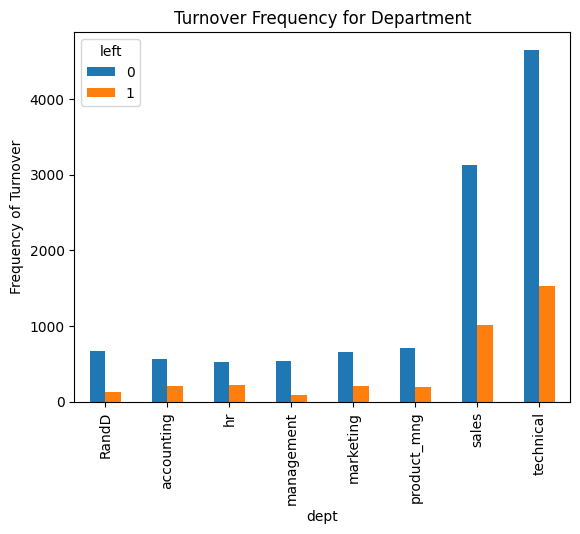

In [7]:
pd.crosstab(hr_data.dept,hr_data.left).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('dept')
plt.ylabel('Frequency of Turnover')
plt.show()

**4. Is salary a factor in employee turnover?**

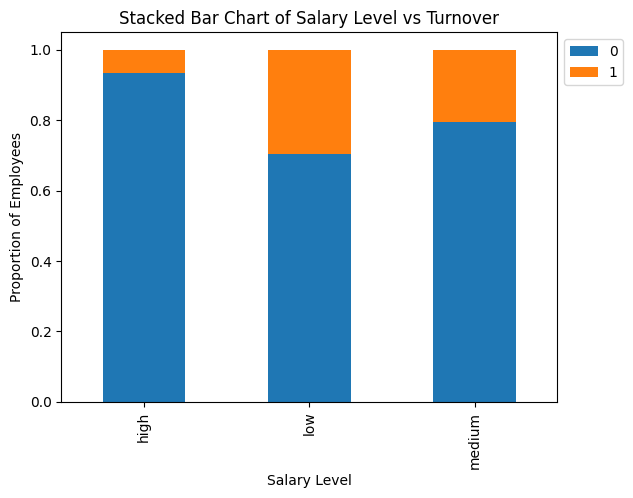

In [15]:
pd.crosstab(hr_data.salary, hr_data.left,normalize='index').plot(kind='bar',stacked=True)
plt.title('Stacked Bar Chart of Salary Level vs Turnover')
plt.xlabel('Salary Level')
plt.ylabel('Proportion of Employees')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**5. Does number or projects have an impact on employee turnover?**

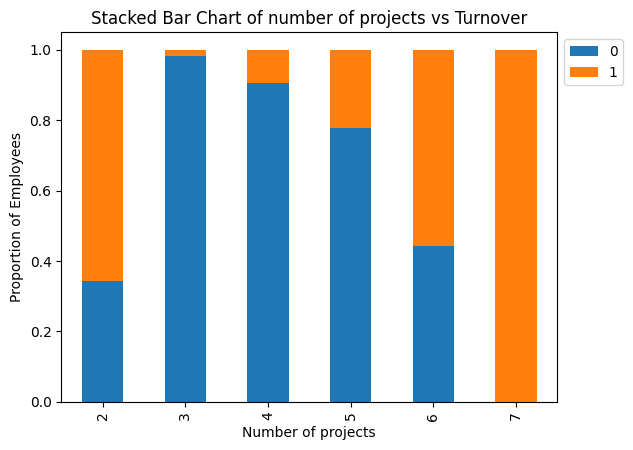

In [16]:
pd.crosstab(hr_data.number_project, hr_data.left,normalize='index').plot(kind='bar',stacked=True)
plt.title('Stacked Bar Chart of number of projects vs Turnover')
plt.xlabel('Number of projects')
plt.ylabel('Proportion of Employees')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**6. Correlations - Heatmap**

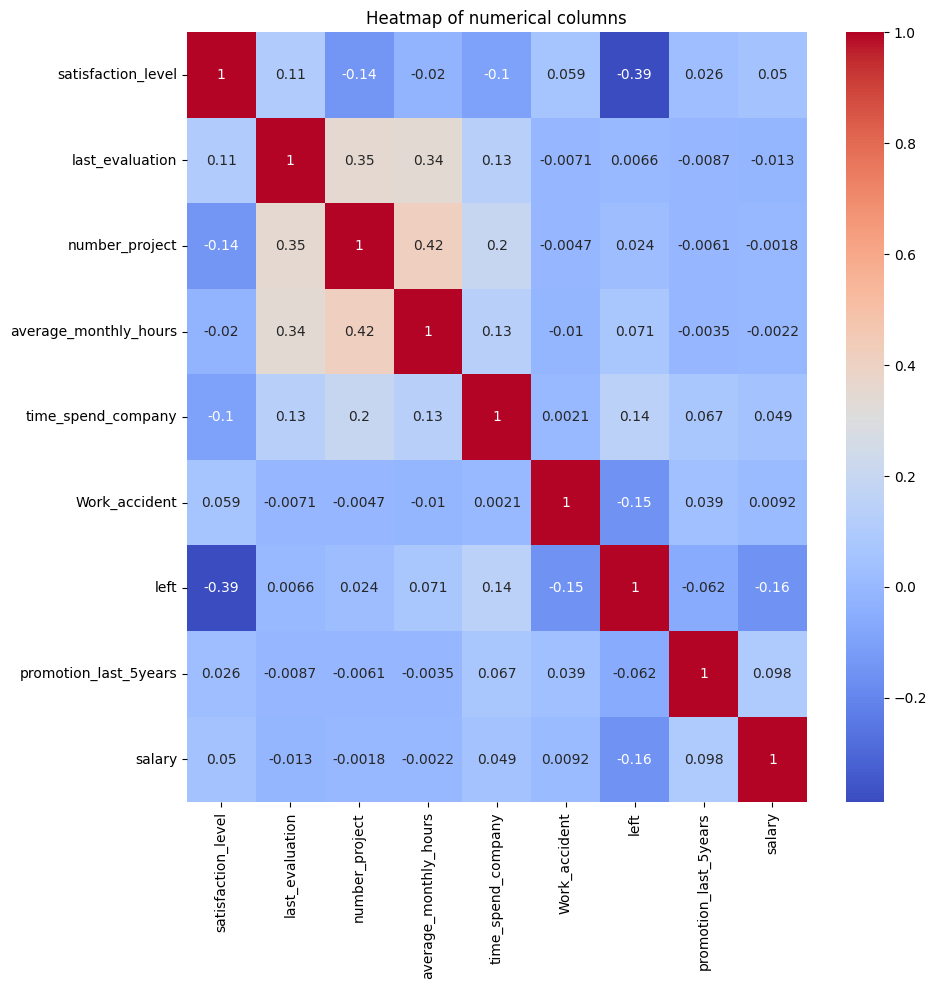

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#encode the salary data
categories = hr_data['salary'].unique()
enc = OrdinalEncoder(categories=[categories])
hr_data['salary'] = enc.fit_transform(pd.DataFrame(hr_data['salary']))
hr_data.drop(['dept'],axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(hr_data.corr(numeric_only=True),annot=True,cmap='coolwarm')
plt.title('Heatmap of numerical columns')
plt.show()

satisfaction_level has a medium negative correlatio with employee leaving.

**7. Distributions - Histograms**

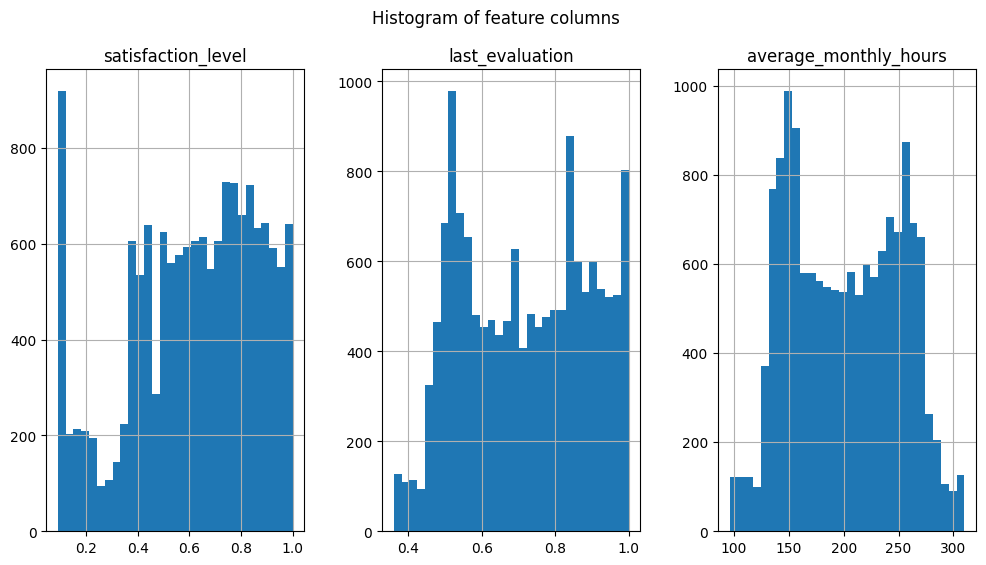

In [ ]:
hr_data.drop(['left'],axis=1).loc[:,['satisfaction_level','last_evaluation','average_monthly_hours']].hist(bins=30,figsize = (12,6),layout=(1,3))
plt.suptitle('Histogram of feature columns')
plt.show()

The above chart shows that employee turnover is high with too few projects or too many projects




**8. Clustering**


**Initial Scatter plot**

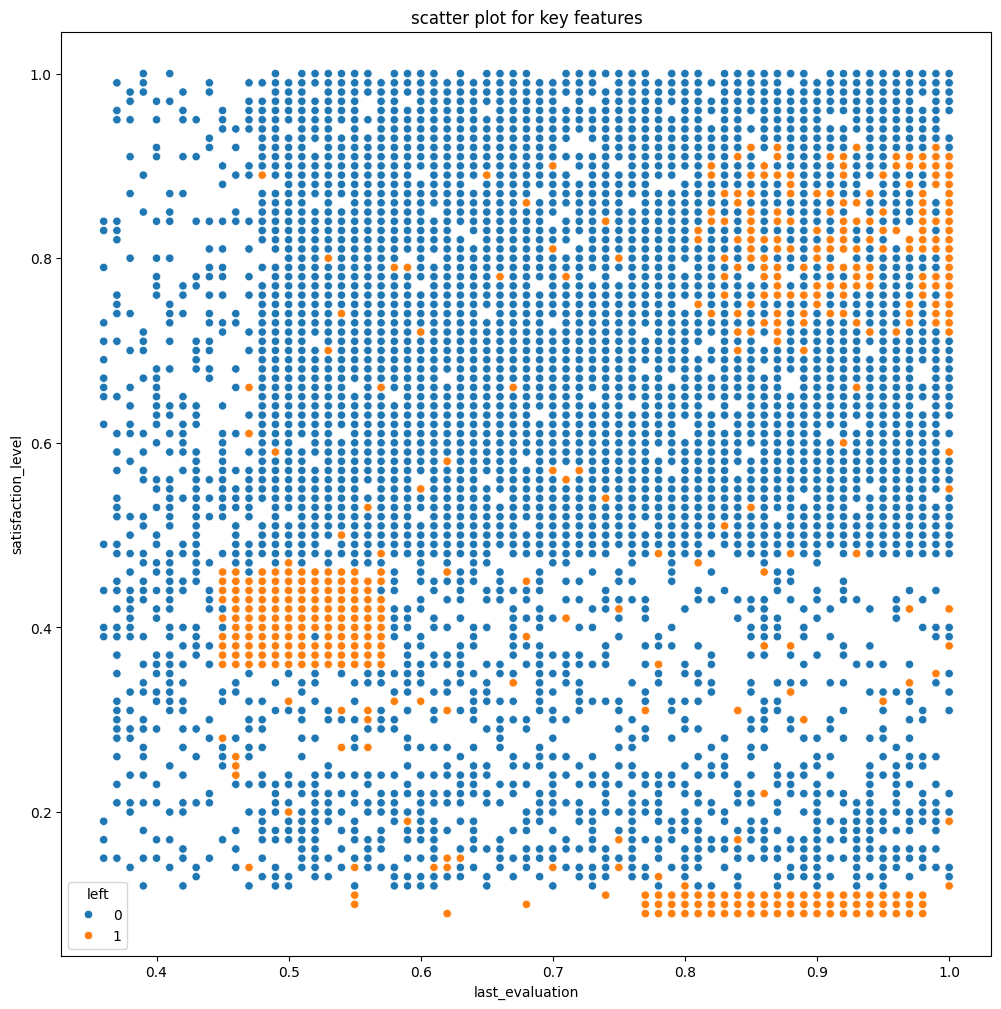

In [ ]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=hr_data,x='last_evaluation',y='satisfaction_level',hue='left')
plt.title('scatter plot for key features')
plt.show()



Looking at the above plot,we see employees leaving for a wide range of satisfaction_level and last_evaluation. However we can also see 3 concentrated regions of employee leaving, but it is not obviuos how many clusters will be optimum for k means clustering. So we will use the elbow curve to find out

**9. Elbow Curve**

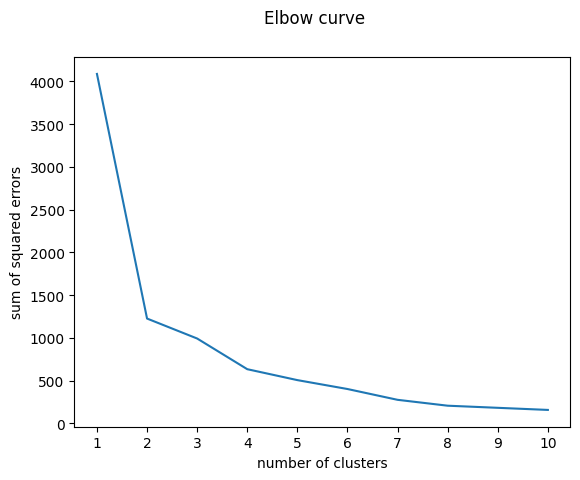

In [ ]:
from sklearn.cluster import KMeans

df = hr_data.loc[:,['satisfaction_level','last_evaluation','left']]
sum_squared_errors = []

for k in range(1,11):
  km = KMeans(n_clusters=k)
  km.fit(df)
  sum_squared_errors.append(km.inertia_)
plt.plot(range(1,11),sum_squared_errors)
plt.xticks(range(1,11))
plt.xlabel('number of clusters')
plt.ylabel('sum of squared errors')
plt.suptitle('Elbow curve')
plt.show()



The above curve as many  elbows and shows that 2,3,4 and 5 are potential values for n_cluster at which points there slope of the elbow curve changes.

**10. Analysis by cluster numbers**

         satisfaction_level  last_evaluation  left
cluster                                           
0                  0.666810         0.715473   0.0
1                  0.440098         0.718113   1.0
         satisfaction_level  last_evaluation  left
cluster                                           
0                  0.666810         0.715473   0.0
1                  0.300270         0.645915   1.0
2                  0.809266         0.908726   1.0
         satisfaction_level  last_evaluation  left
cluster                                           
0                  0.814034         0.738861   0.0
1                  0.300270         0.645915   1.0
2                  0.809266         0.908726   1.0
3                  0.458856         0.682438   0.0
         satisfaction_level  last_evaluation  left
cluster                                           
0                  0.814034         0.738861   0.0
1                  0.458856         0.682438   0.0
2                  0.408687    

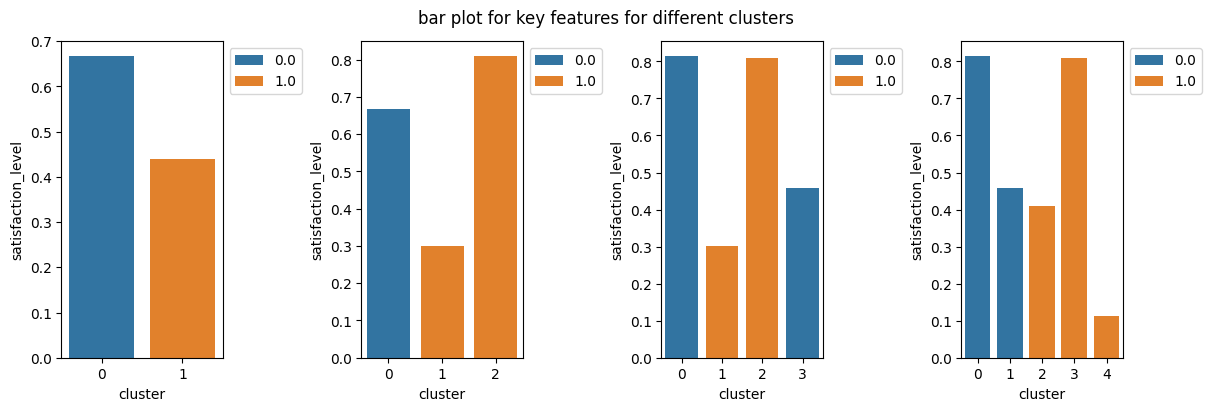

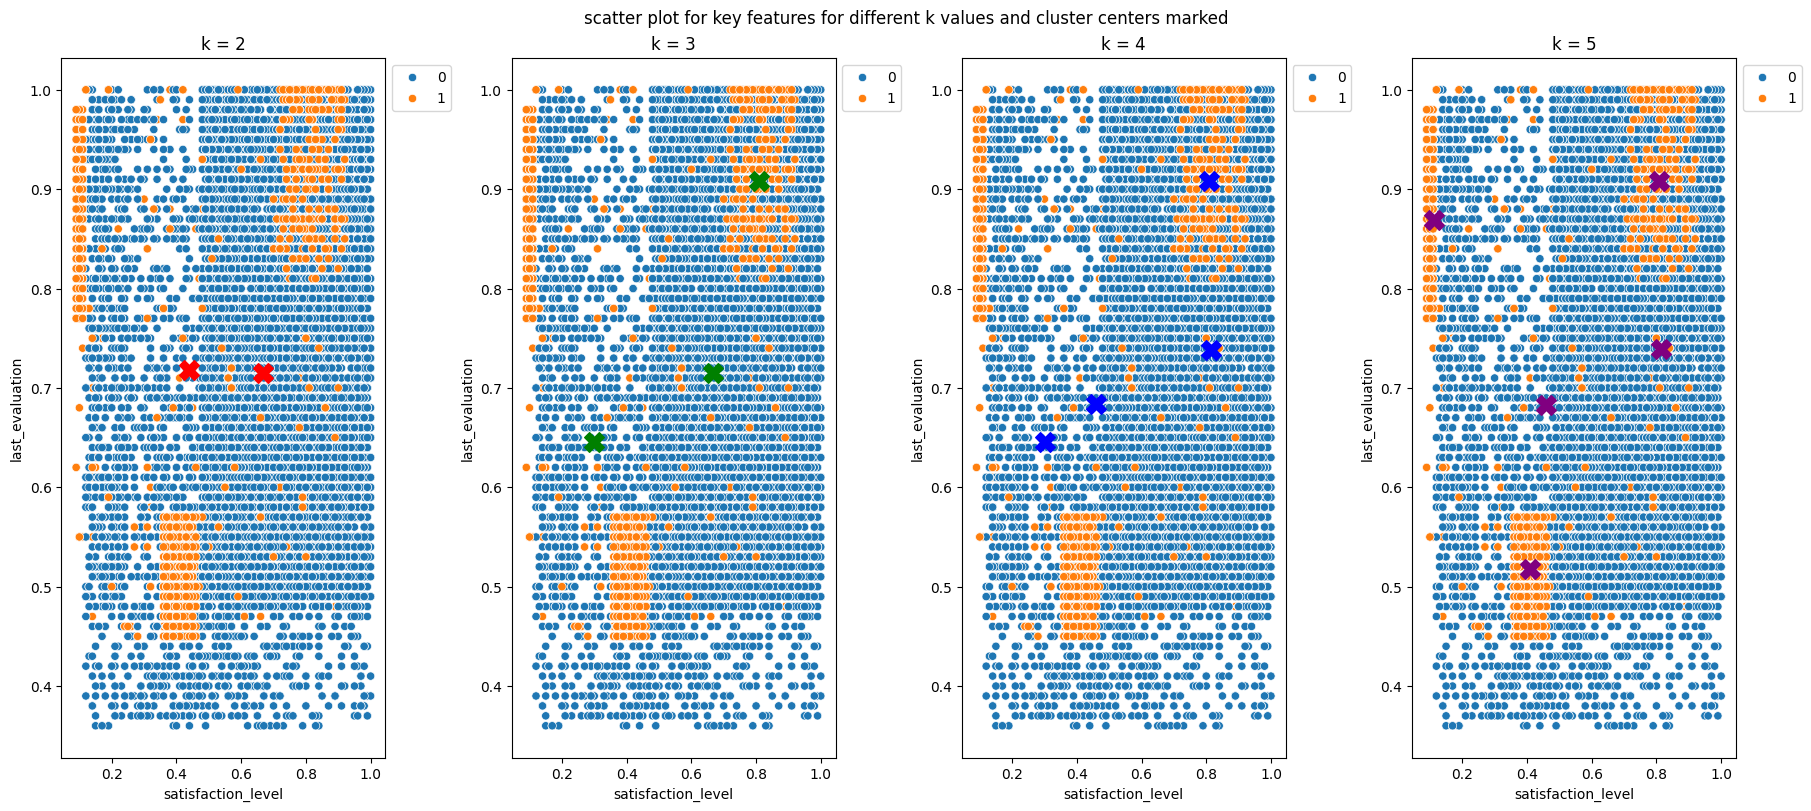

In [ ]:

df = hr_data.loc[:,['satisfaction_level','last_evaluation','left']]
k_values = [2,3,4,5]

fig,axes = plt.subplots(1,len(k_values),figsize=(12,4),layout='constrained')

for i,k in enumerate(k_values):
  km = KMeans(n_clusters=k,random_state=42)
  km.fit(df)
  df['cluster'] = km.predict(df)
  df_cluster_wise = df.groupby('cluster').mean()
  print(df_cluster_wise)
  bars = sns.barplot(data = df_cluster_wise,x='cluster',y='satisfaction_level',hue='left',ax=axes[i])
  bars.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle('bar plot for key features for different clusters')
plt.show()
print()

fig,axes = plt.subplots(1,len(k_values),figsize=(18,8),layout='constrained')
colors = ['red','green','blue','purple']
for i,k in enumerate(k_values):
  km = KMeans(n_clusters=k,random_state=42)
  km.fit(df)
  df['cluster'] = km.predict(df)
  cluster_centers = km.cluster_centers_
  axe = sns.scatterplot(data=df,x='satisfaction_level',y='last_evaluation',hue='left',ax=axes[i] )
  axe.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X',s=200,c=colors[i])
  axe.legend(loc='upper left', bbox_to_anchor=(1, 1))
  axe.set_title(f'k = {k}')
plt.suptitle('scatter plot for key features for different k values and cluster centers marked')
plt.show()




In [ ]:
km


KMeans(n_clusters=5, random_state=42)

K=5 captures the 3 dense clusters of employee leaving in additon to 2 sparse clusters. At all k values we can see that those with a satisfaction_level around 0.5 or less have left. However with 5 clusters, we can also see that a high satisfaction_level and no recent evaluation( high last_evaluation) have also tended to leave. Those who stayed appear to be those whose satisfaction level was average and whose last_evaluation was also neither too old nor too recent.

<i>The random_state parameter of the <code>KMeans.__init__() </code>method determines the output to a large extent. So the above clustering may not be the same for a differnet random_state</i>





**12. Handle the left Class Imbalance using the SMOTE technique**




<class 'pandas.core.frame.DataFrame'>
   left  count
0     0  11428
1     1   3571


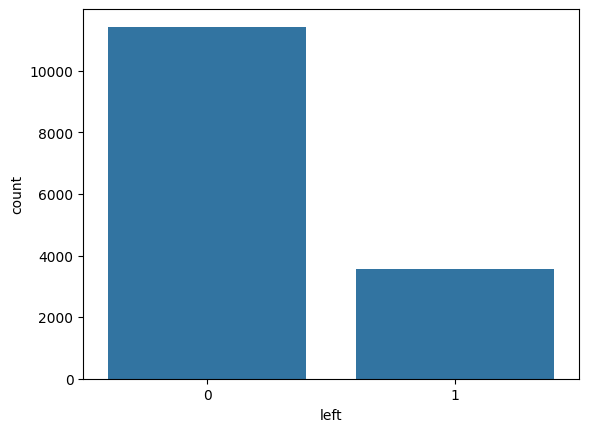

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
class_values = pd.DataFrame(hr_data.value_counts('left')).reset_index()
print(type(class_values))
print(class_values)
sns.barplot(data=class_values,x='left',y='count')
plt.show()

#### Data is  unbalanced and biased towards the minority class(retention or 0 outcomes).  ####

**13. Encode Categorical Data**







In [ ]:
# we can do all of the above in one line of code as the dataset contains just
# one categorical column, viz., dept. We have already encoded the salary column
# values(low, medium,high)with OrdinalEncoder when generating heatmaps

hr_data = pd.get_dummies(hr_data,dtype=int)
print(hr_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   dept_RandD             14999 non-null  int64  
 9   dept_accounting        14999 non-null  int64  
 10  dept_hr                14999 non-null  int64  
 11  dept_management        14999 non-null  int64  
 12  dept_marketing         14999 non-null  int64  
 13  dept_product_mng       14999 non-null  int64  
 14  dept_sales             14999 non-null  int64  
 15  de

**14.SMOTE resampling**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=123)
X = hr_data.drop('left',axis=1)
y = hr_data['left']
print(hr_data.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123) # 80/20 split

print("Before OverSampling, counts of label '1' in train data: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': in train data {}".format(sum(y_train == 0)))
X_train,y_train = sm.fit_resample(X_train,y_train)

print("After OverSampling, counts of label '1' in train data: {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': in train data {}".format(sum(y_train == 0)))



(14999, 19)
Before OverSampling, counts of label '1' in train data: 2862
Before OverSampling, counts of label '0': in train data 9137
After OverSampling, counts of label '1' in train data: 9137
After OverSampling, counts of label '0': in train data 9137


SMOTE analysis has increased the minority class training sample size to the same as that of the majority class.

**15. 5 fold cross validation and performance evaluation**








Evaluating performance for Logistic Regression
Best scores and Best Params

best score = 0.7912344622425287
best params = {'model__C': 0.4, 'model__max_iter': 10000}
Classification Report

Accuracy amd roc_auc scores

accuracy = 0.7643, roc_auc = 0.7498


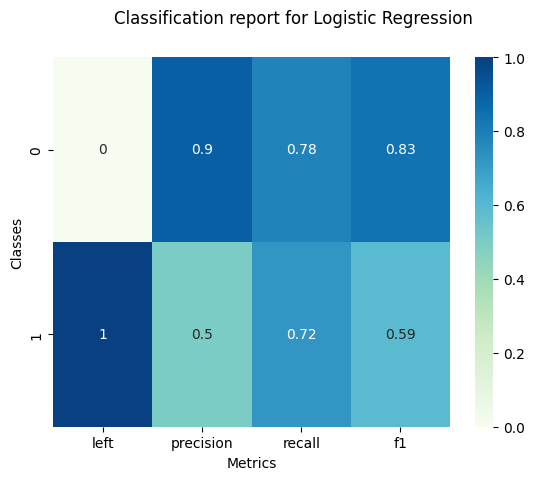

Evaluating performance for Random Forest Classifier
Best scores and Best Params

best score = 0.9849514165463031
best params = {'model__bootstrap': False, 'model__n_estimators': 60}
Classification Report

Accuracy amd roc_auc scores

accuracy = 0.9900, roc_auc = 0.9857


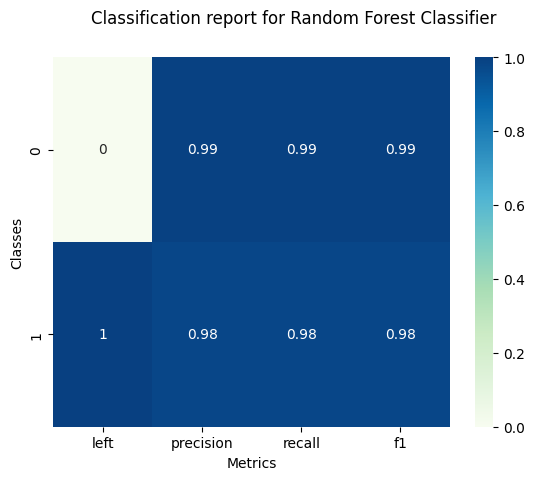

Evaluating performance for Gradient Boosting Classifier
Best scores and Best Params

best score = 0.9600526380025414
best params = {'model__learning_rate': 0.1, 'model__n_estimators': 90}
Classification Report

Accuracy amd roc_auc scores

accuracy = 0.9643, roc_auc = 0.9542


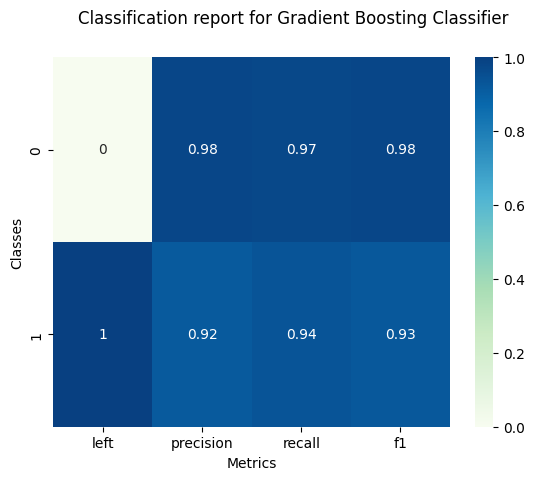

In [ ]:

evaluate_performance('LR',X_train,y_train,X_test,model_name='Logistic Regression',cv = 5)
evaluate_performance('RF',X_train,y_train,X_test,model_name='Random Forest Classifier',cv = 5)
evaluate_performance('GB',X_train,y_train,X_test,model_name='Gradient Boosting Classifier',cv = 5)

The above output show that the Random Forest Classifier performs best with respect to all the metrics.





**16. ROC_AUC curve and Confusion Matrix**

Best scores and Best Params

best score = 0.7973087529585478
best params = {'model__C': 0.1, 'model__max_iter': 10000}
evaluating and visualizing ROC_AUC curve and Confusion Matrix for Logistic Regression

Plotting confusion matrix

confusion matrix
 [[1808  483]
 [ 210  499]]


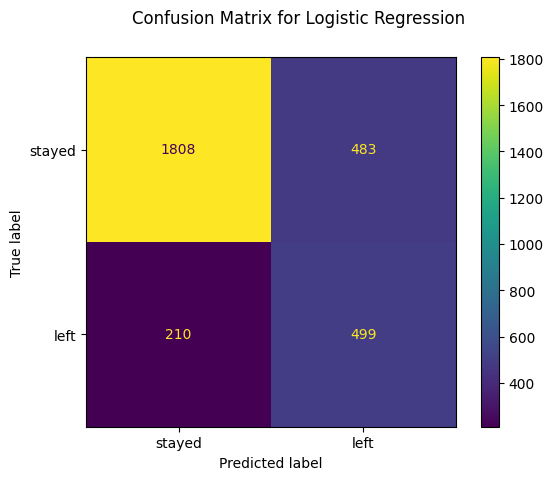

Plotting ROC_AUC curve

auc = 0.8178061082829173



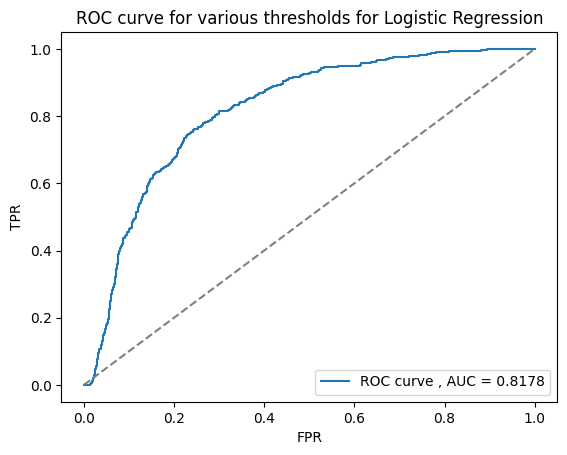

Best scores and Best Params

best score = 0.984294736873632
best params = {'model__bootstrap': False, 'model__n_estimators': 70}
evaluating and visualizing ROC_AUC curve and Confusion Matrix for Random Forest Classifier

Plotting confusion matrix

confusion matrix
 [[2275   16]
 [  17  692]]


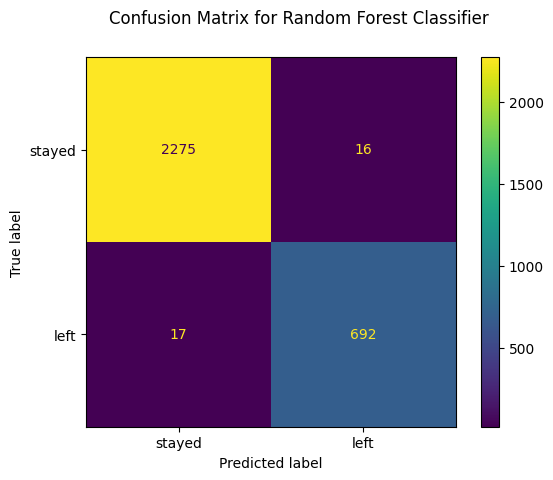

Plotting ROC_AUC curve

auc = 0.9971757394945205



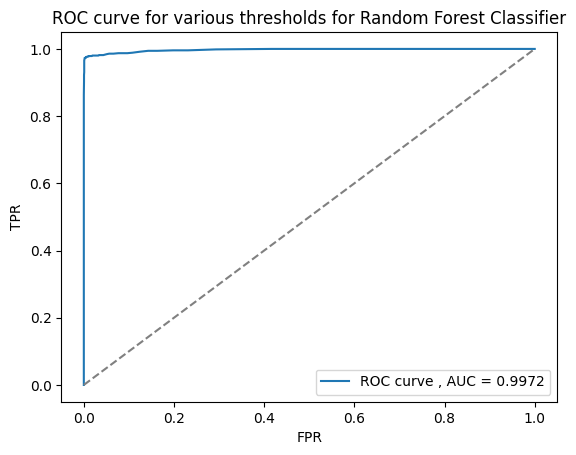

Best scores and Best Params

best score = 0.9583561219194976
best params = {'model__learning_rate': 0.1, 'model__n_estimators': 90}
evaluating and visualizing ROC_AUC curve and Confusion Matrix for Gradient Boosting Classifier

Plotting confusion matrix

confusion matrix
 [[2228   63]
 [  45  664]]


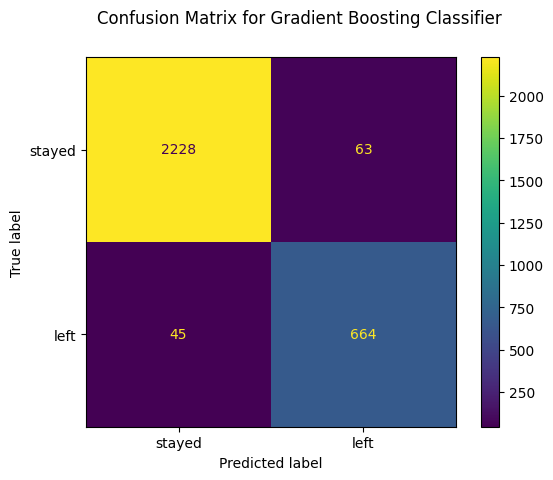

Plotting ROC_AUC curve

auc = 0.988264004792162



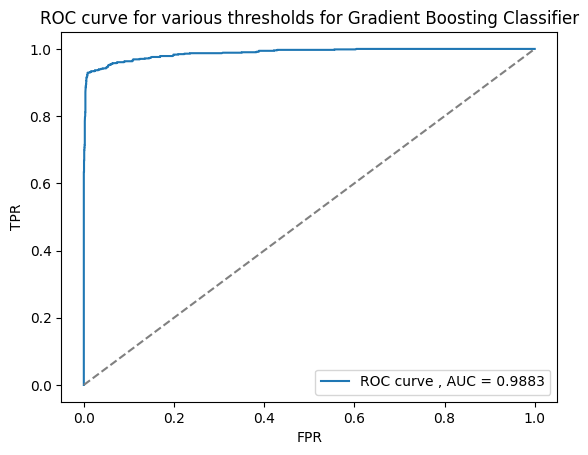

In [ ]:
gs = grid_search_cv('LR',X_train,y_train)
lr_estimator = gs.best_estimator_
pipeline = create_pipeline(lr_estimator,X_train,y_train)
plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name='Logistic Regression')

gs = grid_search_cv('RF',X_train,y_train)
rf_estimator = gs.best_estimator_
pipeline = create_pipeline(rf_estimator,X_train,y_train)
plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name='Random Forest Classifier')

gs = grid_search_cv('GB',X_train,y_train)
gb_estimator = gs.best_estimator_
pipeline = create_pipeline(gb_estimator,X_train,y_train)
plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name='Gradient Boosting Classifier')

Confusion matrix gives the  counts of the following

Recall = TP/TP+FN . That is out of all employees who left, how many did the model predict(recall) correctly? This measurement is called "recall" and a quick look at these diagrams can demonstrate that random forest is clearly best for this criteria. Out of all the turnover cases, random forest correctly retrieved 695 out of 709. This translates to a turnover "recall" of about 98% (695/709), far better than logistic regression (71%) and better than Gradient Boosing Classifier (94%).

Precison = TP/TP+FP. When a classifier predicts an employee will leave, how often does that employee actually leave? This measurement is called "precision". Random forest again out preforms the other two at about 95% precision (991 out of 1045) with logistic regression at about 51% (273 out of 540), and support vector machine at about 77% (890 out of 1150).




**17. Safe Zones and Retention Strategies**





In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=123)
X = hr_data.drop('left',axis=1)
y = hr_data['left']
print(hr_data.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123) # 80/20 split
X_train,y_train = sm.fit_resample(X_train,y_train)
pipeline = create_pipeline(rf_estimator,X_train,y_train)
y_pred_test = pipeline.predict(X_test)
y_pred_test_prob = pipeline.predict_proba(X_test)
y_positive_probability = y_pred_test_prob[:,1]
X_test['pos_probability'] = y_positive_probability
X_test['zones'] = pd.cut(X_test['pos_probability'],bins=[0.0,0.2,0.6,0.9,1],labels=['Safe Zone','Low-Risk Zone','Medium-Risk Zone','High-Risk Zone'])
#The above code puts 0 probablity as NaN. We will change it to safe zone
X_test = X_test.apply(lambda x:x.fillna('Safe Zone'))
X_test.head()

(14999, 19)


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_technical,salary_high,salary_low,salary_medium,pos_probability,zones
6958,0.54,0.67,3,154,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0.000000,Safe Zone
7534,0.72,0.52,3,143,4,1,0,0,0,0,0,0,0,0,1,0,1,0,0.000000,Safe Zone
2975,0.95,0.61,3,267,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0.000000,Safe Zone
3903,0.78,0.79,3,203,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0.114286,Safe Zone
8437,0.60,0.40,3,146,4,1,0,0,0,0,0,0,0,0,1,0,1,0,0.000000,Safe Zone


In [ ]:
key_features_df = X_test[['satisfaction_level','last_evaluation','number_project','average_monthly_hours','zones']]
key_features_df.head()
key_features_df['zones'].value_counts()
grp = key_features_df.groupby('zones',observed=False).mean()
grp

,satisfaction_level,last_evaluation,number_project,average_monthly_hours
zones,,,,
Safe Zone,0.669268,0.717502,3.799818,197.378526
Low-Risk Zone,0.462255,0.776667,3.950980,213.303922
Medium-Risk Zone,0.634400,0.774000,4.120000,227.120000
High-Risk Zone,0.444785,0.717422,3.813333,207.734815


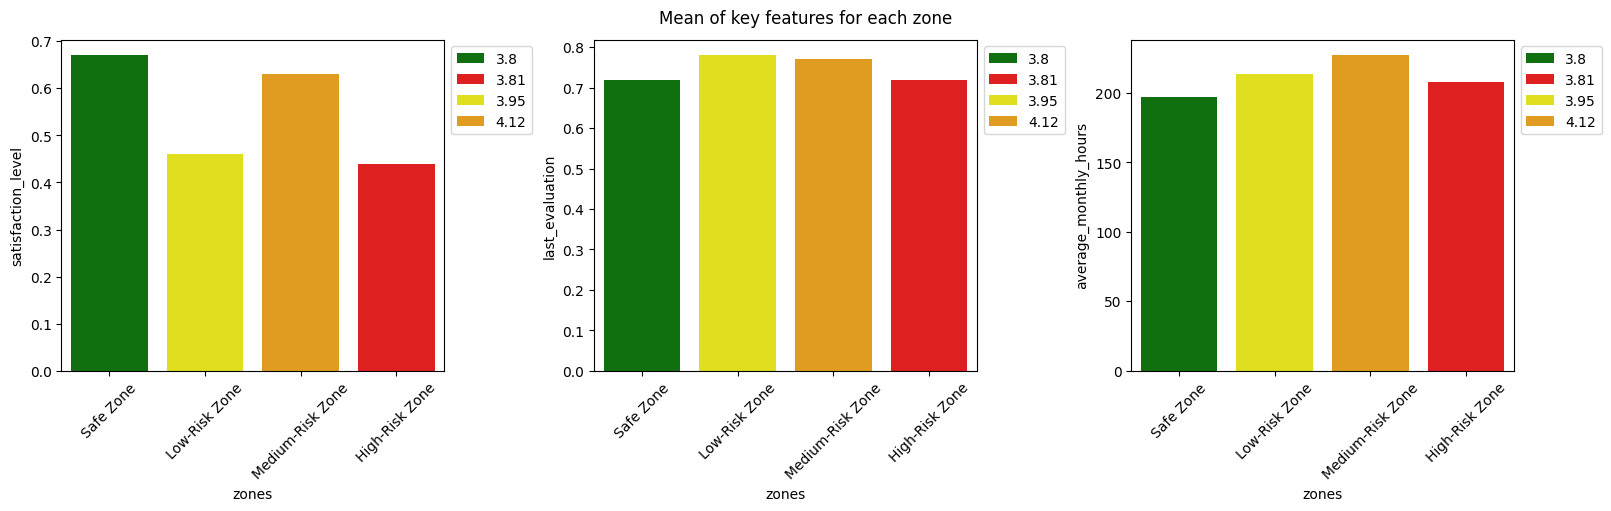

In [ ]:
y = ['satisfaction_level','last_evaluation','average_monthly_hours']
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(16,5),layout='constrained')
for i,y_axis in enumerate(y):
  bars = sns.barplot(data=grp.round(2),x='zones',y=y_axis,ax=axes[i],hue='number_project',palette=['green','red','yellow','orange'] )
  xticks = bars.get_xticklabels()
  bars.set_xticks(bars.get_xticks())
  bars.set_xticklabels(xticks, rotation=45)
  bars.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.xticks(rotation=45)
plt.suptitle('Mean of key features for each zone')
plt.show()


### Recommendation based on the above data: ###

*caveat: The above clustering analysis considers certain features suggested in the problem statement. But we can see that features such as salasry, number or projects etc also have a measurable impact on employee turnover.*




**Suggestions for retention** <p>
<code><i>To increase retention , the company should aim to increase the satisfaction level, have frequent evaluations reduce working hours and striking a right balance on number of projects. From the charts in sections 3 , 4 and 5 above, we also see that certain departments have greater turnover(technical for example) compared to others. Also, as is intuitive , salary is a factor affecting employee turnover.</i></code>